In [1]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import scipy.ndimage as img
import scipy.signal as sig
from PIL import Image, ImageDraw, ImageFont
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"

In [3]:
class ImgModel:
    
    def generate_aperture(rad=0.5, res=500):
        t = np.linspace(-1, 1, res)
        X, Y = np.meshgrid(t,t)
        R = np.hypot(X, Y)
        Z = np.zeros((res, res))
        Z[R <= rad] = 1
        Z = np.round(Z/Z.max() * 255).astype("uint8")
        return Z
        
    def generate_txtImage(x, y, dims=512, text=None, fontsize=256, fontcolor="white", bgcolor="black", supersample=True, superes=128):
        a = Image.new("L", (dims, dims), color=bgcolor)
        fnt = ImageFont.truetype("C:/Windows/Fonts/Arial.ttf", fontsize)
        d = ImageDraw.Draw(a)
        d.text((x, y), text, font=fnt, fill=fontcolor)
        if supersample:
            a = a.resize((superes, superes), Image.ANTIALIAS)
        a = np.array(a, "uint8")
        return a
    
    def image_aperture(obj, aper):
        Faper = fft.fftshift(aper)
        Fobj = fft.fft2(obj)
        FRA = Faper*Fobj
        IRA = abs(fft.fft2(FRA))
        FImage = np.round(IRA/IRA.max() * 255).astype("uint8")
        return FImage
    
def uint8(X):
    return np.round(abs(X)/abs(X).max() * (2**8 - 1)).astype("uint8")

## Activity 1. Familiarization with discrete FFT

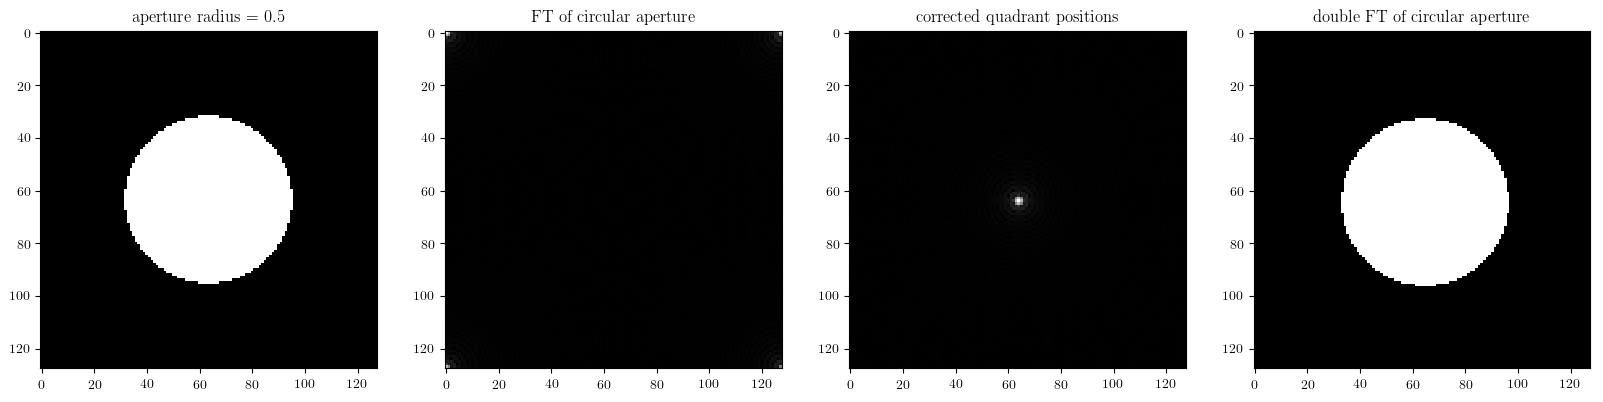

In [8]:
Z = ImgModel.generate_aperture(0.5, 128)
fig = mp.figure(figsize=(5*4, 5))

ax = fig.add_subplot(141)
ax.imshow(Z, "gray")
ax.set_title("aperture radius = 0.5")

ax = fig.add_subplot(142)
FZ = fft.fft2(Z)
ax.imshow(uint8(FZ), "gray")
ax.set_title("FT of circular aperture")

ax = fig.add_subplot(143)
ax.imshow(uint8(fft.fftshift(FZ)), "gray")
ax.set_title("corrected quadrant positions")

ax = fig.add_subplot(144)
ax.imshow(uint8(fft.fft2(FZ)), "gray")
ax.set_title("double FT of circular aperture")

mp.show()

## Activity 2. Simulation of an imaging device

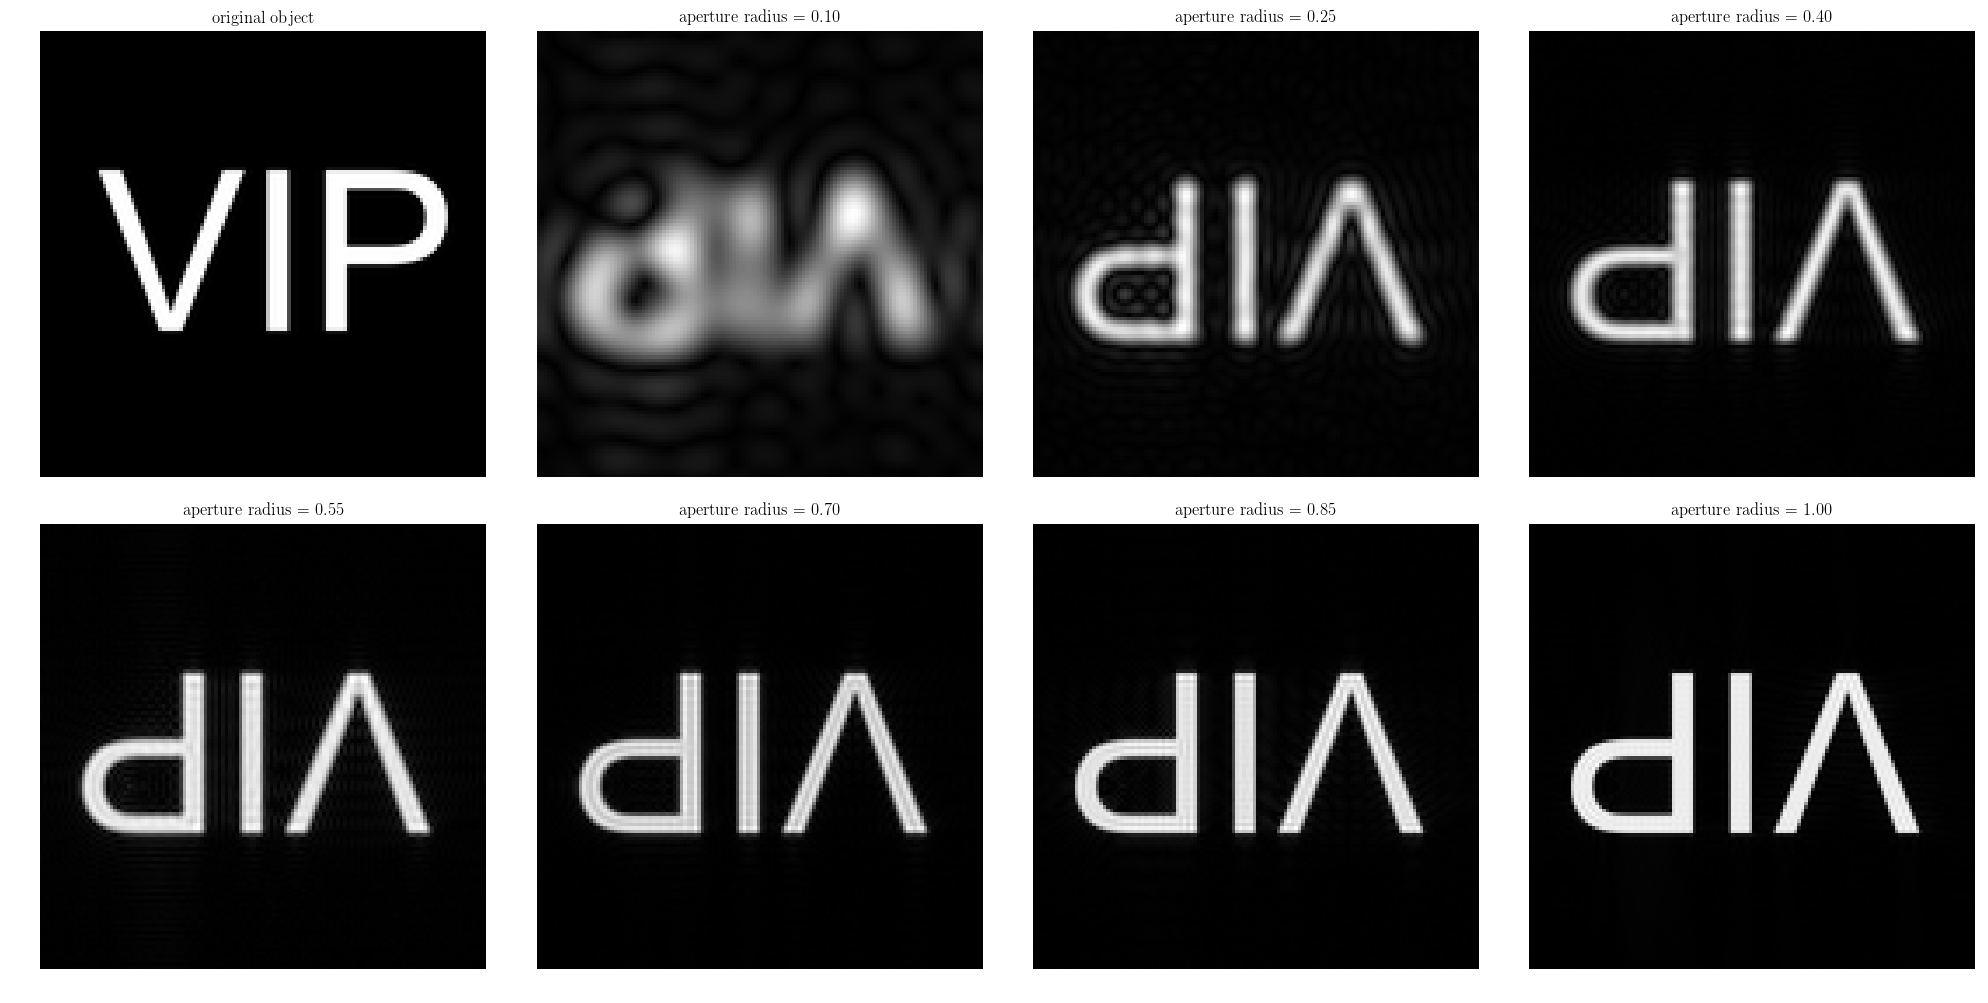

In [9]:
obj = ImgModel.generate_txtImage(66, 112, 512, "VIP", 256, "white", "black", True, 128)
aper_arr = np.linspace(0.1, 1, 7)

fig = mp.figure(figsize=(5*4, 5*2))

ax = fig.add_subplot(241)
ax.imshow(obj, "gray")
ax.axis("off")
ax.set_title("original object")

for i in range(7):
    aper = ImgModel.generate_aperture(rad=aper_arr[i], res=128)
    img = ImgModel.image_aperture(obj, aper)
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(img, "gray")
    ax.set_title("aperture radius = %.2f"%(aper_arr[i]))
    ax.axis("off")

mp.tight_layout()
mp.show()

## Activity 3. Template matching using correlation

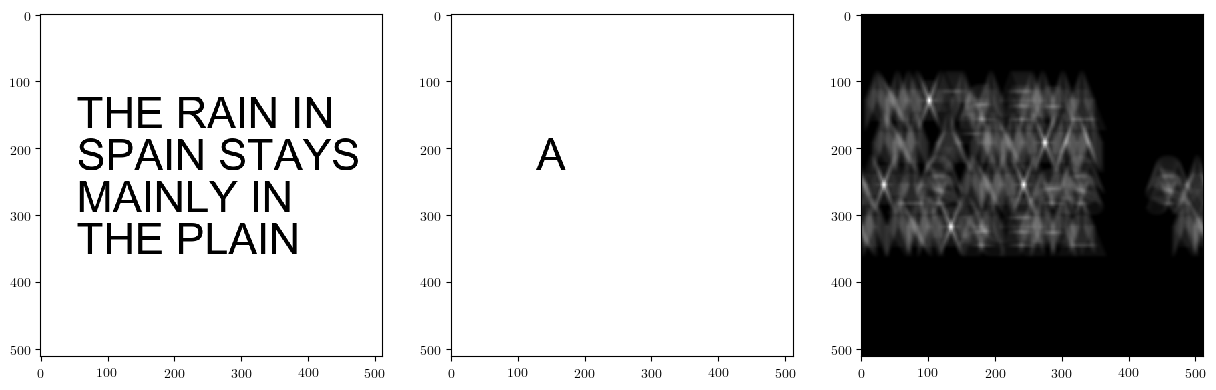

In [12]:
obj = ImgModel.generate_txtImage(55, 112, 512, "THE RAIN IN\nSPAIN STAYS\nMAINLY IN\nTHE PLAIN", 65, "black", "white", True, 512)
temp = ImgModel.generate_txtImage(128, 174, 512, "A", 65, "black", "white", True, 512)

fig = mp.figure(figsize=(5*3, 5))

ax = fig.add_subplot(131)
ax.imshow(obj, "gray")

ax = fig.add_subplot(132)
ax.imshow(temp, "gray")

Fobj = fft.fft2(obj)
Ftemp = fft.fft2(temp)
Fmatch = Ftemp*Fobj.conj()
Fimg = fft.fftshift(abs(fft.ifft2(Fmatch)))
ax = fig.add_subplot(133)
ax.imshow(Fimg, "gray")

mp.show()

## Activity 4. Edge detection using convolution integral

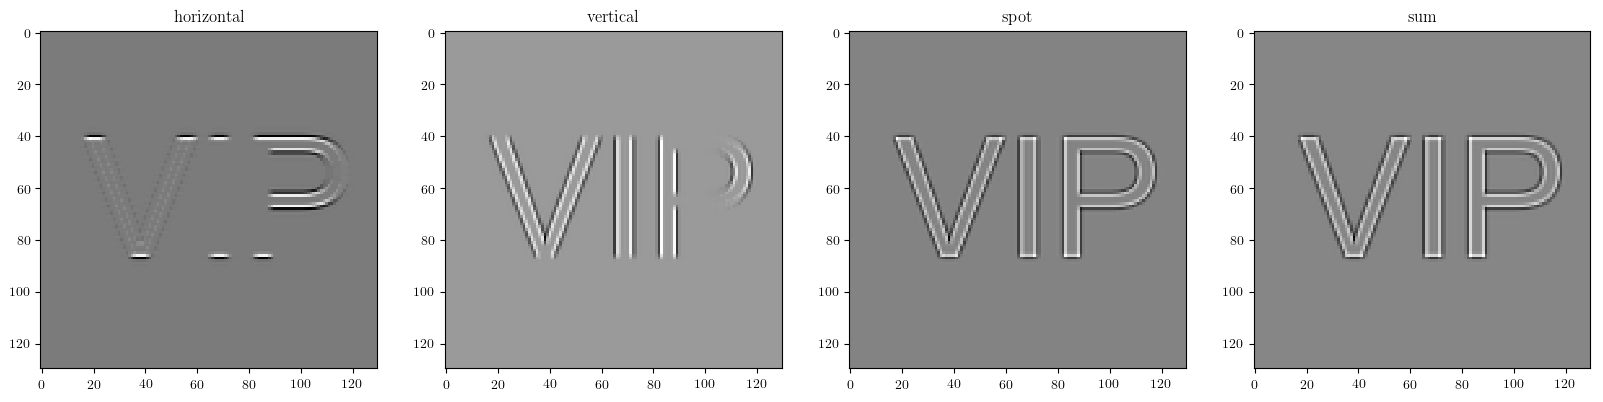

In [13]:
pat1 = np.array([[-1, -1, -1],
               [2, 2, 2],
               [-1, -1, -1]])
pat2 = pat1.T
pat3 = np.array([[-1, -1, -1],
                [-1, 8, -1],
                [-1, -1, -1]])

obj = ImgModel.generate_txtImage(66, 112, 512, "VIP", 256, "white", "black", True, 128)

fig = mp.figure(figsize=(5*4, 5))

img = sig.convolve2d(pat1, obj, "full")
fin = img.copy()
ax = fig.add_subplot(141)
ax.imshow(img, "gray")
ax.set_title("horizontal")

img = sig.convolve2d(pat2, obj, "full")
fin += img
ax = fig.add_subplot(142)
ax.imshow(img, "gray")
ax.set_title("vertical")

img = sig.convolve2d(pat3, obj, "full")
fin += img
ax = fig.add_subplot(143)
ax.imshow(img, "gray")
ax.set_title("spot")

ax = fig.add_subplot(144)
ax.imshow(fin, "gray")
ax.set_title("sum")

mp.show()